## 1) Library & Data Import

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/bourne_scenario.csv")

In [3]:
df.head()

,page_no,scene_title,text
0,1,1 EXT. MERCEDES WINDSHIELD -- DUSK,1 It's raining... ...
1,1,A1 INT. MERCEDES -- NIGHT,A1 On his knee -- a syringe an...
2,1,2 INT. COTTAGE BEDROOM -- NIGHT,2 BOURNE'S EYES OPEN! -- panic...
3,1,A2 INT. COTTAGE LIVING AREA/BATHROOM ...,A2 BOURNE moving for the medic...
4,2,3 INT./EXT. COTTAGE LIVING ROOM/VERA...,3 One minute later. BOURNE mo...


#### Feature Description
- page_no : 데이터가 위치한 pdf 페이지 정보
- scene_title : 씬 제목
- text : 씬에 해당하는 지문/대본 텍스트 정보

-----

## 2) 데이터셋 살펴보기

### 2-1) 기본 정보 탐색

##### 데이터셋 기본 정보 탐색

In [4]:
df.shape

(320, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   page_no      320 non-null    int64 
 1   scene_title  320 non-null    object
 2   text         320 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.6+ KB


In [8]:
df.isnull().sum()

page_no        0
scene_title    0
text           0
dtype: int64

In [7]:
df['text'][0]

" 1                It's raining...                Light strobes across the wet glass at a rhythmic pace...                 Suddenly -- through the window a face -- JASON BOURNE --               riding in the backseat -- his gaze fixed.      "

-----

## 3) 텍스트 데이터 전처리

### 3-1) 정규 표현식 적용

In [9]:
# 공백, 특수문자 거르고 대소문자를 소문자로 통일
import re

def apply_regular_expression(text):
  text = text.lower()
  english = re.compile('[^ a-z]')   # 띄어쓰기를 포함한 알파벳 영어 추출
  result = english.sub('',text)     # 정규표현식을 text에 적용
  result = re.sub(' +',' ',result)  # 띄어쓰기 2개 이상인것 하나로 만들기
  return result

In [10]:
# 함수 테스트
apply_regular_expression(df['text'][0])

' its raining light strobes across the wet glass at a rhythmic pace suddenly through the window a face jason bourne riding in the backseat his gaze fixed '

In [11]:
df['processed_text'] = df['text'].apply(lambda x: apply_regular_expression(x))
df.head()

,page_no,scene_title,text,processed_text
0,1,1 EXT. MERCEDES WINDSHIELD -- DUSK,1 It's raining... ...,its raining light strobes across the wet glas...
1,1,A1 INT. MERCEDES -- NIGHT,A1 On his knee -- a syringe an...,a on his knee a syringe and a gun the eyes of...
2,1,2 INT. COTTAGE BEDROOM -- NIGHT,2 BOURNE'S EYES OPEN! -- panic...,bournes eyes open panicked gasping trying to ...
3,1,A2 INT. COTTAGE LIVING AREA/BATHROOM ...,A2 BOURNE moving for the medic...,a bourne moving for the medicine cabinet digs...
4,2,3 INT./EXT. COTTAGE LIVING ROOM/VERA...,3 One minute later. BOURNE mo...,one minute later bourne moves out onto the ve...


### 3-2) Word Count

##### 말뭉치(코퍼스) 생성

In [ ]:
# 말뭉치 생성
corpus = df['processed_text'].tolist()
corpus

##### BoW 벡터 생성

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# filter stop words
vect = CountVectorizer(tokenizer=None, stop_words="english", analyzer='word').fit(corpus) # tokenizer : 문장단위를 어떻게 나눌건지, stop_words : 불용어 설정(실질적인 의미가 없는것 걸러줌), analyzer : 단어단위로
bow_vect = vect.fit_transform(corpus)
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [17]:
word_list[:5]

['aa', 'ab', 'abandoned', 'abandons', 'abbott']

In [16]:
count_list[:5] # word_list에 나온 저 단어들이 얼마나 나왔는지 볼 수 있다

array([  3,   3,   2,   1, 128])

In [18]:
bow_vect.shape

(320, 2850)

In [19]:
bow_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
bow_vect.toarray().sum(axis=0)

array([ 3,  3,  2, ...,  1, 42,  3])

In [22]:
# 단어별 타입된 횟수 딕셔너리로
word_count_dict = dict(zip(word_list, count_list))
print(str(word_count_dict)[:100])

{'aa': 3, 'ab': 3, 'abandoned': 2, 'abandons': 1, 'abbott': 128, 'abbottnow': 1, 'abbottphone': 4, '


In [23]:
# 빈도수 순 정렬
import operator
sorted(word_count_dict.items(), key=operator.itemgetter(1), reverse=True)[:5]

[('bourne', 455),
 ('pamela', 199),
 ('abbott', 128),
 ('hes', 100),
 ('kirill', 93)]

##### 단어 분포 탐색

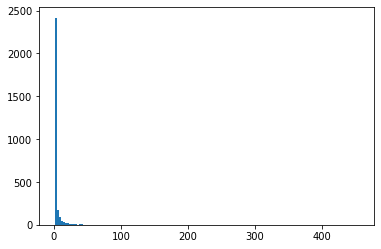

In [27]:
plt.hist(list(word_count_dict.values()), bins=150)
plt.show()

-----

## 4) 텍스트 마이닝

### 4-1) 단어별 빈도 분석

##### 워드 클라우드 시각화

In [ ]:
# !pip install pytagcloud pygame simplejson

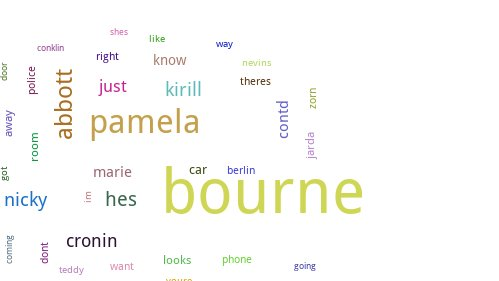

In [31]:
from collections import Counter

import random
import pytagcloud
import webbrowser

ranked_tags = Counter(word_count_dict).most_common(25) # 가장많이 나온 단어 상위 25개를 불러옴
taglist = pytagcloud.make_tags(sorted(word_count_dict.items(), key=operator.itemgetter(1), reverse=True)[:40], maxsize=60)
pytagcloud.create_tag_image(taglist, 'wordcloud_example.jpg', rectangular=False)  # taglist : 이미지 생성, 뒤에 이름, 직사각형여부

from IPython.display import Image
Image(filename='wordcloud_example.jpg')  # 이미지 출력

##### 상위 빈도수 단어 출력

In [32]:
ranked_tags

[('bourne', 455),
 ('pamela', 199),
 ('abbott', 128),
 ('hes', 100),
 ('kirill', 93),
 ('nicky', 90),
 ('cronin', 81),
 ('just', 80),
 ('marie', 67),
 ('contd', 63),
 ('know', 61),
 ('car', 51),
 ('away', 48),
 ('room', 44),
 ('jarda', 43),
 ('looks', 43),
 ('dont', 42),
 ('zorn', 42),
 ('phone', 40),
 ('right', 39),
 ('theres', 39),
 ('police', 38),
 ('want', 38),
 ('berlin', 37),
 ('teddy', 35)]

-----

### 4-2) 장면별 중요 단어 시각화

##### TF-IDF 변환

In [33]:
# text의 의미 점수부여
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [34]:
print(tf_idf_vect.shape)
print(tf_idf_vect[0])

(320, 2850)
  (0, 2788)	0.19578974958217082
  (0, 2763)	0.27550455848587985
  (0, 2412)	0.1838379942679887
  (0, 2387)	0.3109660261831164
  (0, 1984)	0.2902223973596984
  (0, 1978)	0.3109660261831164
  (0, 1898)	0.27550455848587985
  (0, 1673)	0.2902223973596984
  (0, 1366)	0.21520447034992146
  (0, 1251)	0.19855583314180728
  (0, 1001)	0.2340173008390438
  (0, 974)	0.2902223973596984
  (0, 874)	0.27550455848587985
  (0, 798)	0.1906694714764746
  (0, 237)	0.08646242181596513
  (0, 125)	0.26408851574819875


In [36]:
print(tf_idf_vect[0].toarray().shape)
print(tf_idf_vect[0].toarray())

(1, 2850)
[[0. 0. 0. ... 0. 0. 0.]]


##### 벡터 : 단어 맵핑

In [39]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'..')

{1898: 'raining', 1366: 'light', 2387: 'strobes', 2763: 'wet', 1001: 'glass', 1978: 'rhythmic', 1673..


In [ ]:
vect.vocabulary_

##### 중요 단어 추출 - Top 3 TF-IDF

In [40]:
# 첫번째 문장의 tf_idf 값이 높은 순으로 정렬(3개)
np.argsort(tf_idf_vect[0].toarray())[0][-3:]

array([1984, 2387, 1978])

In [ ]:
np.argsort(tf_idf_vect.toarray())[:, -3:]

In [42]:
top_3_word = np.argsort(tf_idf_vect.toarray())[:, -3:]
df['important_word_indexes'] = pd.Series(top_3_word.tolist())
df.head()

,page_no,scene_title,text,processed_text,important_word_indexes
0,1,1 EXT. MERCEDES WINDSHIELD -- DUSK,1 It's raining... ...,its raining light strobes across the wet glas...,"[1984, 2387, 1978]"
1,1,A1 INT. MERCEDES -- NIGHT,A1 On his knee -- a syringe an...,a on his knee a syringe and a gun the eyes of...,"[1297, 1971, 1097]"
2,1,2 INT. COTTAGE BEDROOM -- NIGHT,2 BOURNE'S EYES OPEN! -- panic...,bournes eyes open panicked gasping trying to ...,"[1693, 2221, 968]"
3,1,A2 INT. COTTAGE LIVING AREA/BATHROOM ...,A2 BOURNE moving for the medic...,a bourne moving for the medicine cabinet digs...,"[690, 299, 1482]"
4,2,3 INT./EXT. COTTAGE LIVING ROOM/VERA...,3 One minute later. BOURNE mo...,one minute later bourne moves out onto the ve...,"[2823, 1951, 1454]"


In [43]:
def convert_to_word(x):
    word_list = []
    for word in x:
        word_list.append(invert_index_vectorizer[word])
    return word_list

In [44]:
df['important_words'] = df['important_word_indexes'].apply(lambda x: convert_to_word(x))
df.head()

,page_no,scene_title,text,processed_text,important_word_indexes,important_words
0,1,1 EXT. MERCEDES WINDSHIELD -- DUSK,1 It's raining... ...,its raining light strobes across the wet glas...,"[1984, 2387, 1978]","[riding, strobes, rhythmic]"
1,1,A1 INT. MERCEDES -- NIGHT,A1 On his knee -- a syringe an...,a on his knee a syringe and a gun the eyes of...,"[1297, 1971, 1097]","[knee, returns, head]"
2,1,2 INT. COTTAGE BEDROOM -- NIGHT,2 BOURNE'S EYES OPEN! -- panic...,bournes eyes open panicked gasping trying to ...,"[1693, 2221, 968]","[panicked, sleeps, gasping]"
3,1,A2 INT. COTTAGE LIVING AREA/BATHROOM ...,A2 BOURNE moving for the medic...,a bourne moving for the medicine cabinet digs...,"[690, 299, 1482]","[downs, cabinet, medicine]"
4,2,3 INT./EXT. COTTAGE LIVING ROOM/VERA...,3 One minute later. BOURNE mo...,one minute later bourne moves out onto the ve...,"[2823, 1951, 1454]","[write, remember, marie]"


## 1) Library & Data Import

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/tripadviser_review.csv")

In [3]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


#### Feature Description
- rating : 이용자 리뷰의 평가 점수
- text : 이용자 리뷰 평가 내용

-----

## 2) 데이터셋 살펴보기

### 2-1) 기본 정보 탐색

##### 데이터셋 기본 정보 탐색

In [4]:
df.shape

(1001, 2)

In [5]:
df.isnull().sum()

rating    0
text      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  1001 non-null   int64 
 1   text    1001 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [7]:
df['text'][0]

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다.'

In [10]:
df['text'][100]

'올 봄에 벚꽃기간에 방문, 협재를 바라보는 바다뷰가 좋고 대로변이라 렌트해서 가기도 좋음. 조식은 이용안했는데 근처 옹포밥집까지 아침 산책겸 걸어가서 하고옴. 루프탑 수영장과 바가 있었는데 내가 갔을때는 밤에 비바람이 너무 불어서 이용못하고옴 ㅠㅠ  단점으로는 모 유명 여행블로거 리뷰처럼 화장실 물떄가... 그거빼곤 다 만족'

In [8]:
len(df['text'].values.sum())

223576

-----

## 3) 한국어 텍스트 데이터 전처리

### 3-0) konlpy 설치

In [ ]:
# konlpy 0.5.2의 JVM 버그로 인해, 0.5.1 버전으로 install
!pip install konlpy==0.5.1 jpype1 Jpype1-py3

### 3-1) 정규표현식 적용

In [12]:
import re

# 띄어쓰기 포함한 한글 받아서 넣기 / 띄어쓰기를 두번이상 하는 경우가 거의 없다고 판단
def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]') # 한글의 정규표현식
    result = hangul.sub('', text)
    return result

In [13]:
apply_regular_expression(df['text'][0])

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다'

In [14]:
apply_regular_expression(df['text'][100])

'올 봄에 벚꽃기간에 방문 협재를 바라보는 바다뷰가 좋고 대로변이라 렌트해서 가기도 좋음 조식은 이용안했는데 근처 옹포밥집까지 아침 산책겸 걸어가서 하고옴 루프탑 수영장과 바가 있었는데 내가 갔을때는 밤에 비바람이 너무 불어서 이용못하고옴 ㅠㅠ  단점으로는 모 유명 여행블로거 리뷰처럼 화장실 물떄가 그거빼곤 다 만족'

-----

### 3-2) 한국어 형태소분석 - 명사 단위

##### 명사 형태소 추출

In [15]:
from konlpy.tag import Okt
from collections import Counter

nouns_tagger = Okt()
nouns = nouns_tagger.nouns(apply_regular_expression(df['text'][0]))

In [16]:
nouns

['여행', '집중', '휴식', '제공', '호텔', '위치', '선정', '또한', '청소', '청결', '상태']

In [17]:
# 전체 말뭉치(corpus)에서 명사 형태소 추출
nouns = nouns_tagger.nouns(apply_regular_expression("".join(df['text'].tolist())))

In [18]:
# 빈도 탐색
counter = Counter(nouns)
counter.most_common(10)

[('호텔', 803),
 ('수', 498),
 ('것', 436),
 ('방', 330),
 ('위치', 328),
 ('우리', 327),
 ('곳', 320),
 ('공항', 307),
 ('직원', 267),
 ('매우', 264)]

##### 한글자 명사 제거

In [19]:
available_counter = Counter({x : counter[x] for x in counter if len(x) > 1})  # 한글자 이상의 단어만 출력
available_counter.most_common(10)

[('호텔', 803),
 ('위치', 328),
 ('우리', 327),
 ('공항', 307),
 ('직원', 267),
 ('매우', 264),
 ('가격', 245),
 ('객실', 244),
 ('시설', 215),
 ('제주', 192)]

-----

### 3-3) 불용어 사전

In [20]:
# source - https://www.ranks.nl/stopwords/korean
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
print(stopwords[:10])

[['휴'], ['아이구'], ['아이쿠'], ['아이고'], ['어'], ['나'], ['우리'], ['저희'], ['따라'], ['의해']]


In [21]:
# 데이터 특징을 반영한 불용어 추가
jeju_hotel_stopwords = ['제주', '제주도', '호텔', '리뷰', '숙소', '여행', '트립']
for word in jeju_hotel_stopwords:
    stopwords.append(word)

-----

### 3-4) Word Count

##### BoW 벡터 생성

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)
    tagger = Okt()
    nouns = nouns_tagger.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]
    nouns = [x for x in nouns if x not in stopwords]
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df['text'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [55]:
word_list

['가가',
 '가게',
 '가격',
 '가격표',
 '가구',
 '가급',
 '가기',
 '가까이',
 '가끔',
 '가능',
 '가도',
 '가동',
 '가두',
 '가득',
 '가든',
 '가라',
 '가량',
 '가려움',
 '가로',
 '가면',
 '가몬',
 '가무',
 '가물',
 '가미',
 '가방',
 '가버',
 '가성',
 '가세',
 '가스레인지',
 '가스렌지',
 '가슴',
 '가시',
 '가신',
 '가야',
 '가옥',
 '가요',
 '가용',
 '가운데',
 '가을',
 '가인',
 '가장',
 '가정',
 '가정식',
 '가족',
 '가지',
 '가짓수',
 '가차',
 '가치',
 '가품',
 '각각',
 '각오',
 '각자',
 '각종',
 '각층',
 '간격',
 '간곳',
 '간다',
 '간단',
 '간만',
 '간식',
 '간이',
 '간주',
 '간직',
 '간판',
 '간혹',
 '갈껄',
 '갈비',
 '갈비탕',
 '갈수',
 '갈수록',
 '감각',
 '감동',
 '감명',
 '감사',
 '감상',
 '감소',
 '감안',
 '감자',
 '감히',
 '갑인',
 '갑자기',
 '갑작스레',
 '강남',
 '강력',
 '강아지',
 '강압',
 '강제',
 '강조',
 '강추',
 '개념',
 '개략',
 '개미',
 '개발',
 '개방',
 '개별',
 '개보',
 '개뿔',
 '개선',
 '개수대',
 '개월',
 '개인',
 '개인실',
 '개인정보',
 '개조',
 '개층',
 '객수',
 '객실',
 '갤러리',
 '갱스터',
 '거기',
 '거나',
 '거두',
 '거론',
 '거르세',
 '거름',
 '거리',
 '거린데',
 '거림',
 '거문도',
 '거미',
 '거부',
 '거실',
 '거여',
 '거울',
 '거위',
 '거의',
 '거절',
 '거주',
 '거지',
 '거참',
 '거품',
 '걱정',
 '건가',
 '건강',
 '건너',
 '건너편',
 '건물',
 '건의',
 '건조',


In [24]:
count_list

array([  4,   8, 245, ...,   1,   7,  14])

In [25]:
bow_vect.shape

(1001, 3599)

In [26]:
bow_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
bow_vect.toarray().sum(axis=0)

array([  4,   8, 245, ...,   1,   7,  14])

In [28]:
bow_vect.toarray().sum(axis=0).shape

(3599,)

In [56]:
word_count_dict = dict(zip(word_list, count_list))
word_count_dict

{'가가': 4,
 '가게': 8,
 '가격': 245,
 '가격표': 1,
 '가구': 8,
 '가급': 1,
 '가기': 20,
 '가까이': 20,
 '가끔': 5,
 '가능': 10,
 '가도': 7,
 '가동': 2,
 '가두': 1,
 '가득': 2,
 '가든': 1,
 '가라': 3,
 '가량': 1,
 '가려움': 1,
 '가로': 2,
 '가면': 14,
 '가몬': 1,
 '가무': 1,
 '가물': 1,
 '가미': 1,
 '가방': 4,
 '가버': 1,
 '가성': 49,
 '가세': 3,
 '가스레인지': 1,
 '가스렌지': 1,
 '가슴': 1,
 '가시': 4,
 '가신': 3,
 '가야': 10,
 '가옥': 1,
 '가요': 5,
 '가용': 1,
 '가운데': 3,
 '가을': 4,
 '가인': 1,
 '가장': 42,
 '가정': 4,
 '가정식': 2,
 '가족': 94,
 '가지': 55,
 '가짓수': 3,
 '가차': 1,
 '가치': 15,
 '가품': 1,
 '각각': 7,
 '각오': 1,
 '각자': 2,
 '각종': 3,
 '각층': 1,
 '간격': 2,
 '간곳': 1,
 '간다': 4,
 '간단': 1,
 '간만': 1,
 '간식': 5,
 '간이': 3,
 '간주': 1,
 '간직': 1,
 '간판': 2,
 '간혹': 1,
 '갈껄': 1,
 '갈비': 1,
 '갈비탕': 1,
 '갈수': 7,
 '갈수록': 1,
 '감각': 1,
 '감동': 12,
 '감명': 1,
 '감사': 6,
 '감상': 3,
 '감소': 1,
 '감안': 5,
 '감자': 1,
 '감히': 1,
 '갑인': 1,
 '갑자기': 4,
 '갑작스레': 1,
 '강남': 1,
 '강력': 9,
 '강아지': 7,
 '강압': 2,
 '강제': 1,
 '강조': 1,
 '강추': 8,
 '개념': 1,
 '개략': 1,
 '개미': 1,
 '개발': 3,
 '개방': 2,
 '개별': 3,
 '개보': 1,
 '개뿔': 1,


-----

### 3-5) TF-IDF 적용

##### TF-IDF 변환

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [31]:
print(tf_idf_vect.shape)
print(tf_idf_vect[0])

(1001, 3599)
  (0, 3588)	0.35673213299026796
  (0, 2927)	0.2582351368959594
  (0, 2925)	0.320251680858207
  (0, 2866)	0.48843555212083145
  (0, 2696)	0.23004450213863206
  (0, 2311)	0.15421663035331626
  (0, 1584)	0.48843555212083145
  (0, 1527)	0.2928089229786031
  (0, 790)	0.2528176728459411


##### 벡터 : 단어 맵핑

In [32]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'..')

{2866: '집중', 3588: '휴식', 2696: '제공', 2311: '위치', 1584: '선정', 790: '또한', 2927: '청소', 2925: '청결', 1527..


-----

## 4) Logistic Regression 분류

### 4-1) 데이터셋 생성

##### Rating 데이터 이진으로 변환

In [33]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


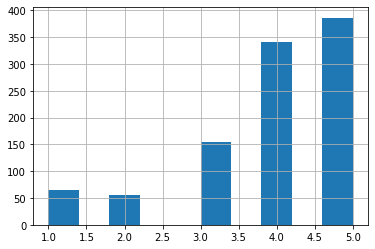

In [34]:
df.rating.hist()

In [35]:
def rating_to_label(rating):
    if rating > 3:
        return 1
    else:
        return 0

df['y'] = df['rating'].apply(lambda x: rating_to_label(x))

In [36]:
df.head()

,rating,text,y
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...,1
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입...",1
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...,1
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...,1
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...,1


In [37]:
df.y.value_counts()

1    726
0    275
Name: y, dtype: int64

-----

### 4-2) 데이터셋 분리

In [38]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size=0.30)

In [39]:
print(x_train.shape)
print(x_test.shape)

(700, 3599)
(301, 3599)


-----

### 4-3) 모델 학습

##### Logistic Regression 학습

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train LR model
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# classifiacation predict
y_pred = lr.predict(x_test)

##### 분류 결과 평가

In [41]:
# classification result for test dataset
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.74
Precision : 0.732
Recall : 1.000
F1 : 0.845


In [42]:
from sklearn.metrics import confusion_matrix

# print confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[  6  79]
 [  0 216]]


-----

### 4-4) 샘플링 재조정

##### 1:1 Sampling

In [43]:
positive_random_idx = df[df['y']==1].sample(275, random_state=33).index.tolist()
negative_random_idx = df[df['y']==0].sample(275, random_state=33).index.tolist()

In [44]:
# dataset split to train/test
random_idx = positive_random_idx + negative_random_idx
X = tf_idf_vect[random_idx]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

In [45]:
print(x_train.shape)
print(x_test.shape)

(412, 3599)
(138, 3599)


##### 모델 재학습

In [46]:
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

##### 분류 결과 평가

In [47]:
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.72
Precision : 0.644
Recall : 0.797
F1 : 0.712


In [48]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[53 26]
 [12 47]]


-----

## 5) 긍정/부정 키워드 분석

##### Logistic Regression 모델의 coef 분석

<BarContainer object of 3599 artists>

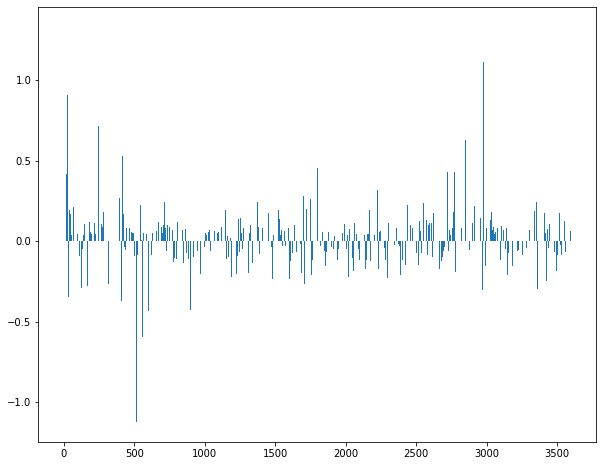

In [49]:
# print logistic regression's coef
# 단어의 분포 확인
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

##### 긍정/부정 키워드 출력

In [50]:
# 긍정/부정키워드 5개씩
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(1.3321308087111168, 2400), (1.1098677278465363, 2977), (1.029120247844704, 1247), (0.9474432432978868, 2957), (0.9049132254229898, 26)]
[(-0.6491883332225628, 363), (-0.6683241824194205, 3538), (-0.6811855513119685, 1909), (-0.9632209931825515, 1293), (-1.124500886987929, 515)]


In [ ]:
# 상위 5개 인덱스
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=False)
coef_pos_index

In [52]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}

In [53]:
for coef in coef_pos_index[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

이용 1.3321308087111168
추천 1.1098677278465363
버스 1.029120247844704
최고 0.9474432432978868
가성 0.9049132254229898
근처 0.8631251640260484
조식 0.8624237330200107
다음 0.7848182816732695
위치 0.732990219026413
공간 0.716865493140725
시설 0.7161355390234533
맛집 0.7134163462461057
거리 0.7044600617626677
분위기 0.6869152801231841
바다 0.6556108465327279


In [54]:
for coef in coef_neg_index[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

냄새 -1.124500886987929
별로 -0.9632209931825515
아무 -0.6811855513119685
화장실 -0.6683241824194205
그냥 -0.6491883332225628
모기 -0.6302873381425533
수건 -0.6243491941007028
느낌 -0.5975494080979522
모텔 -0.5971174361320487
다른 -0.5966138818945081
최악 -0.593317479621261
음식 -0.5443424935120069
주위 -0.5321043465183405
진짜 -0.5254380815734122
목욕 -0.5087212885846032
